In [95]:
from typing import Dict
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plot import plot_hbar_groups

In [96]:
COLORS = {
    "chainguard": "blue",
    "rapidfort": "firebrick",
    "alpine": "pink",
    "original": "gray"
}

def format_df(df: pd.DataFrame, column: str) -> Dict:
    registries = df["registry_type"].unique()
    images = df["image_type"].unique()
    members = {r: [] for r in registries}

    for reg in registries:
        for img in images:
            tmask = df["registry_type"] == reg
            imask = df["image_type"] == img
            filtered = df[tmask & imask][column]
            if filtered.shape[0] == 0:
                val = 0
            else:
                val = filtered.iloc[0]
            members[reg].append(val)
    
    return members, images

def plot_df(df: pd.DataFrame, column: str):
    _, ax = plt.subplots(figsize=(10,20))
    members, groups = format_df(df, column)
    plot_hbar_groups(ax, members, groups, COLORS)

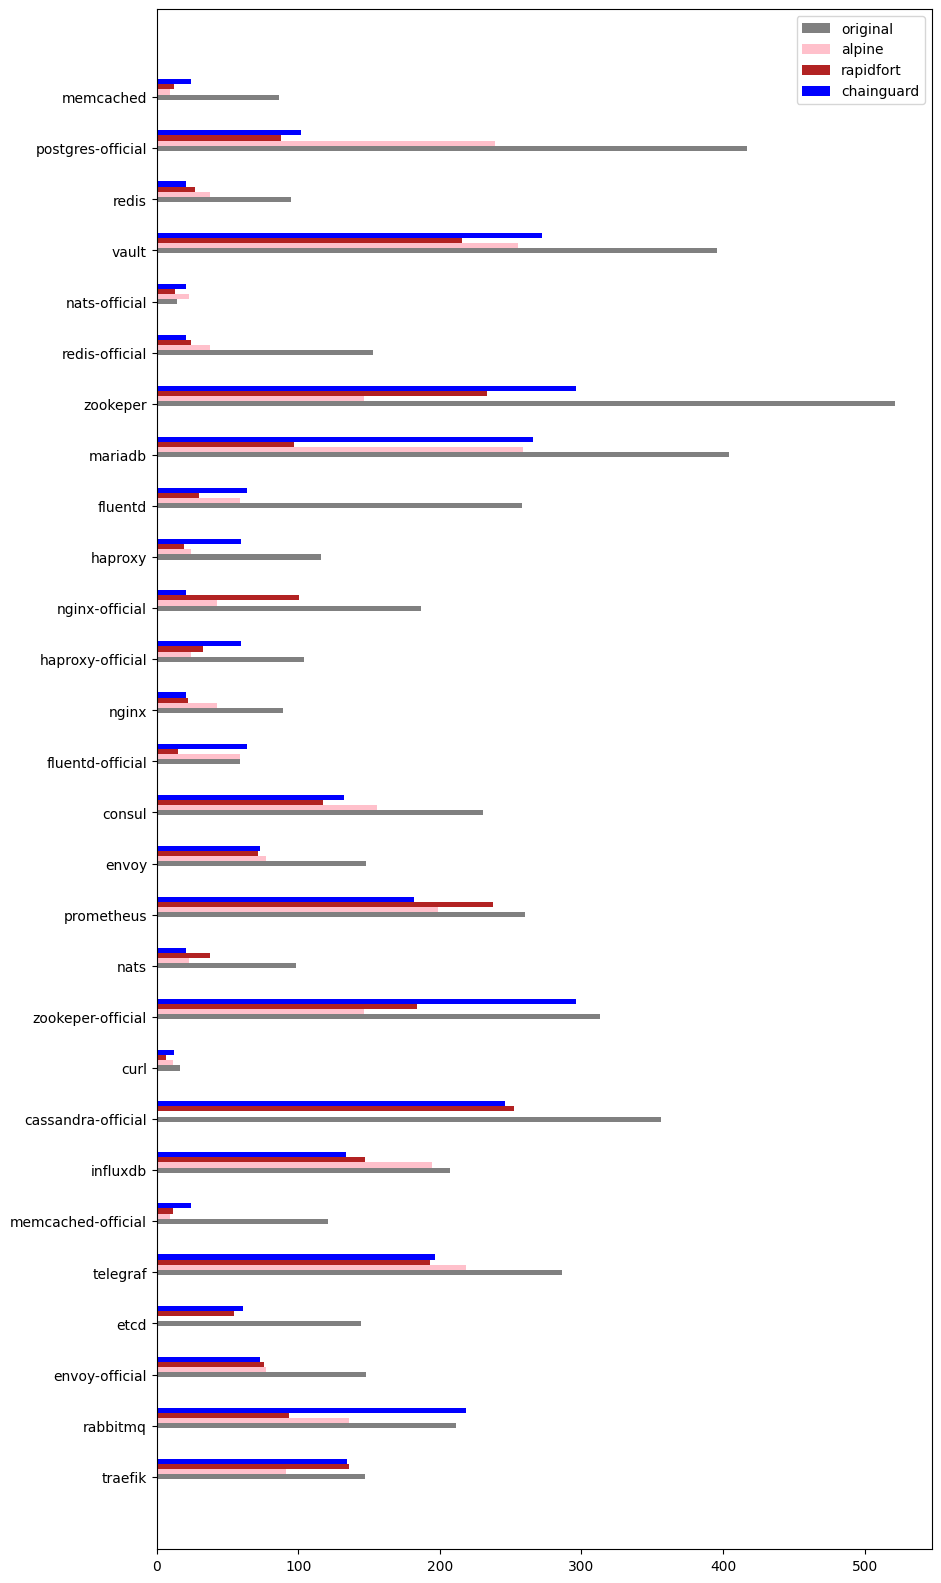

In [101]:
# Image size by registry
sz_df = pd.read_csv(os.path.join("data", "out", "metadata.csv"))

sz_df["image_size"] = sz_df["image_size"] / 1000000
plot_df(sz_df, "image_size")

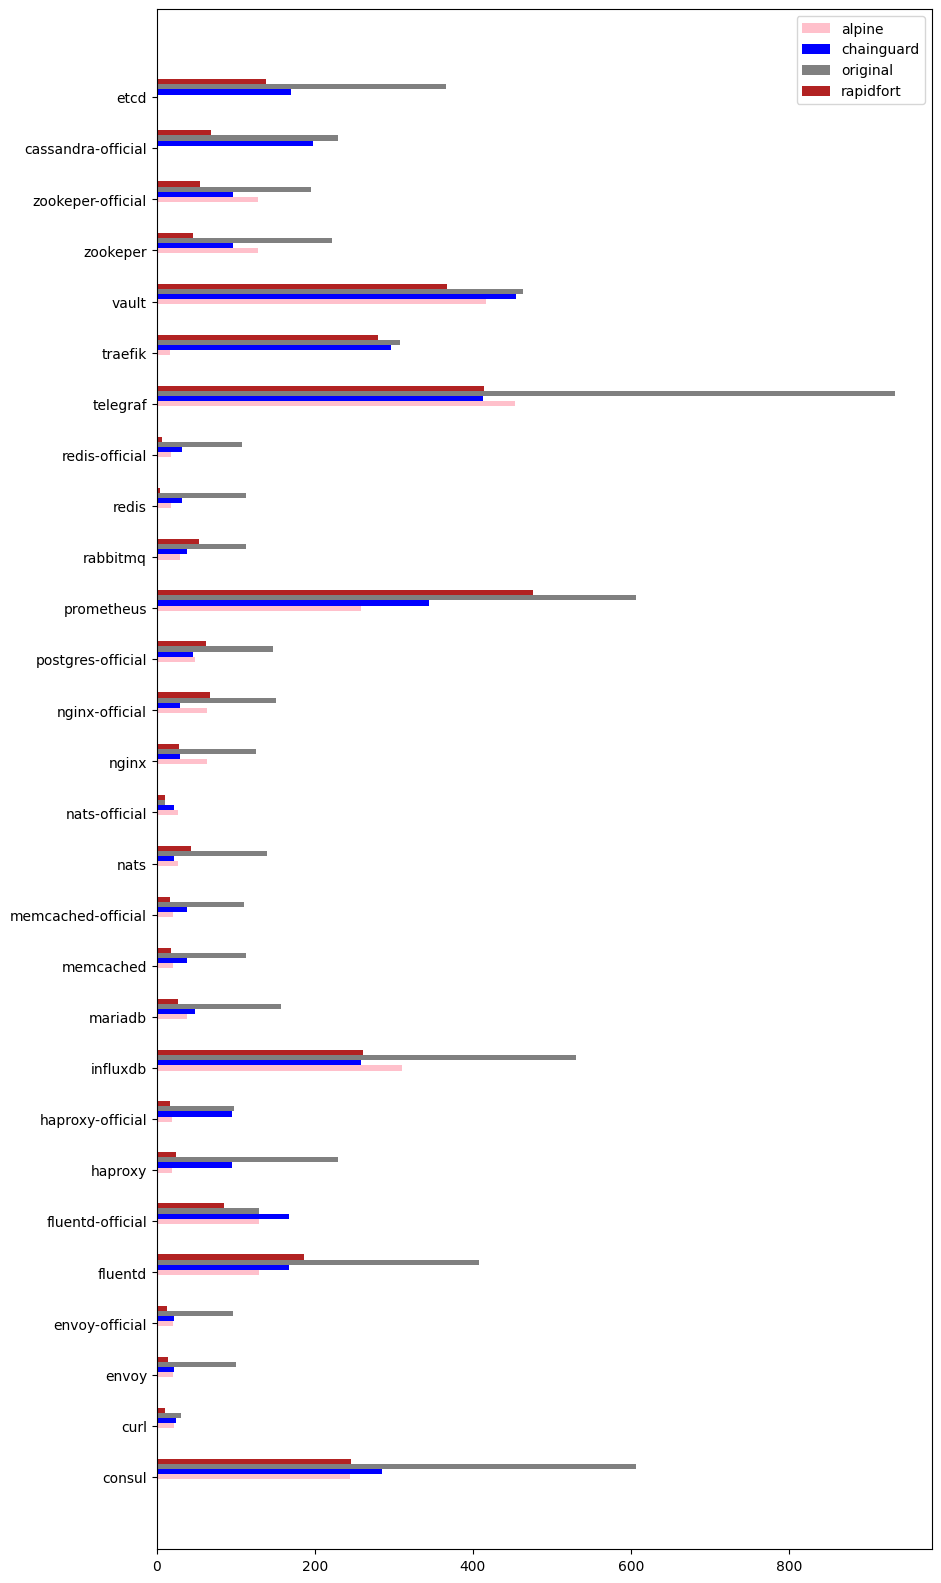

In [102]:
# Number of components by registry
comps_df = pd.read_csv(os.path.join("data", "out", "components.csv"))
comps_df = comps_df.drop(["type"], axis=1) \
                    .groupby(["registry_type", "image_type"]) \
                    .count() \
                    .reset_index() \
                    .rename(columns={"component_name": "n_components"})

plot_df(comps_df, "n_components")

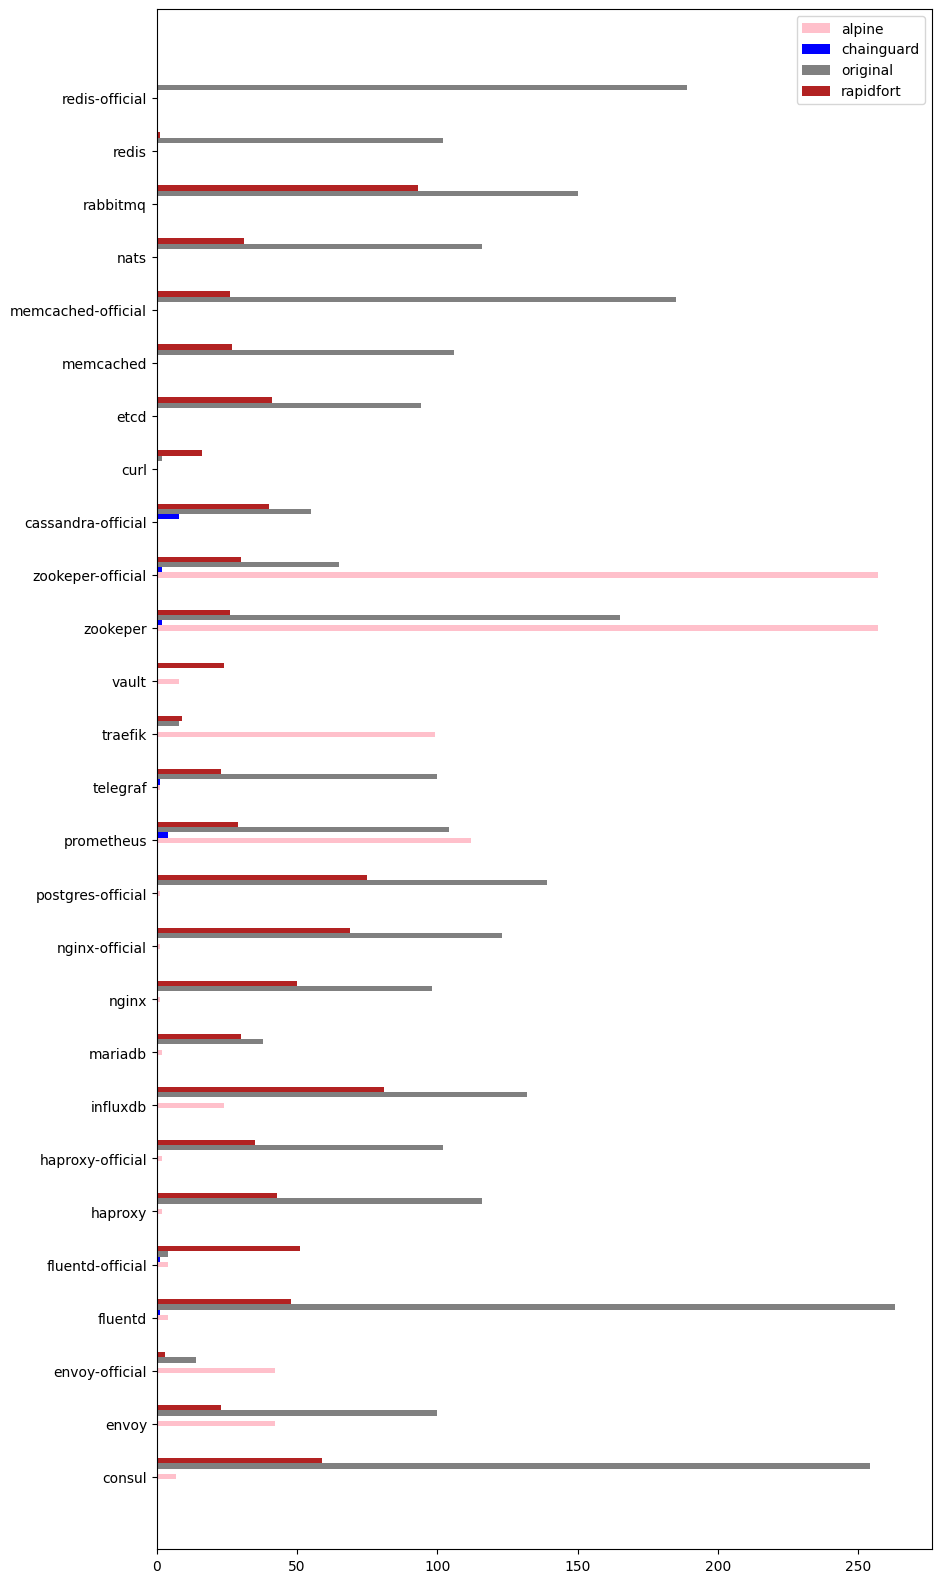

In [103]:
# Number of vulns by registry
vulns_df = pd.read_csv(os.path.join("data", "out", "vulns.csv"))
vulns_df = vulns_df.drop(["type"], axis=1) \
                   .groupby(["registry_type", "image_type"]) \
                   .count() \
                   .reset_index() \
                   .rename(columns={"severity": "n_vulns"})

plot_df(vulns_df, "n_vulns")

In [104]:
# Merge data

df = vulns_df.merge(sz_df, how="left",
                    on=["registry_type", "image_type"])

df = df.merge(comps_df, how="left",
              on=["registry_type", "image_type"])

df["vpm"] = df["n_vulns"] / df["image_size"]
df["vpc"] = df["n_vulns"] / df["n_components"]

df.groupby("registry_type").describe()

n_vulns                                                    \
                count        mean        std  min    25%    50%     75%   
registry_type                                                             
alpine           18.0   48.111111  82.975467  1.0   2.00    5.5   42.00   
chainguard        7.0    2.714286   2.563480  1.0   1.00    2.0    3.00   
original         26.0  108.615385  68.025335  2.0  72.25  103.0  137.25   
rapidfort        26.0   37.807692  23.096353  1.0  24.50   30.5   49.50   

                     image_size              ...       vpm             vpc  \
                 max      count        mean  ...       75%       max count   
registry_type                                ...                             
alpine         257.0       18.0  128.342246  ...  0.544134  1.753628  18.0   
chainguard       8.0        7.0  191.979550  ...  0.018864  0.032514   7.0   
original       263.0       26.0  199.073689  ...  1.059373  1.529976  26.0   
rapidfort       93.0       26.0   96.561126  ...  1.467343  3.448198  26.0   

                                                                           \
                   mean       std       min       25%       50%       75%   
registry_type                                                               
alpine         0.832074  1.506012  0.002203  0.022478  0.064901  1.614387   
chainguard     0.015376  0.013164  0.002421  0.005988  0.011594  0.020619   
original       0.622743  0.491023  0.025974  0.240641  0.574478  0.929204   
rapidfort      0.833839  0.665455  0.032143  0.252016  0.589855  1.488636   

                         
                    max  
registry_type            
alpine         5.823529  
chainguard     0.040404  
original       1.750000  
rapidfort      2.058824  

[4 rows x 40 columns]

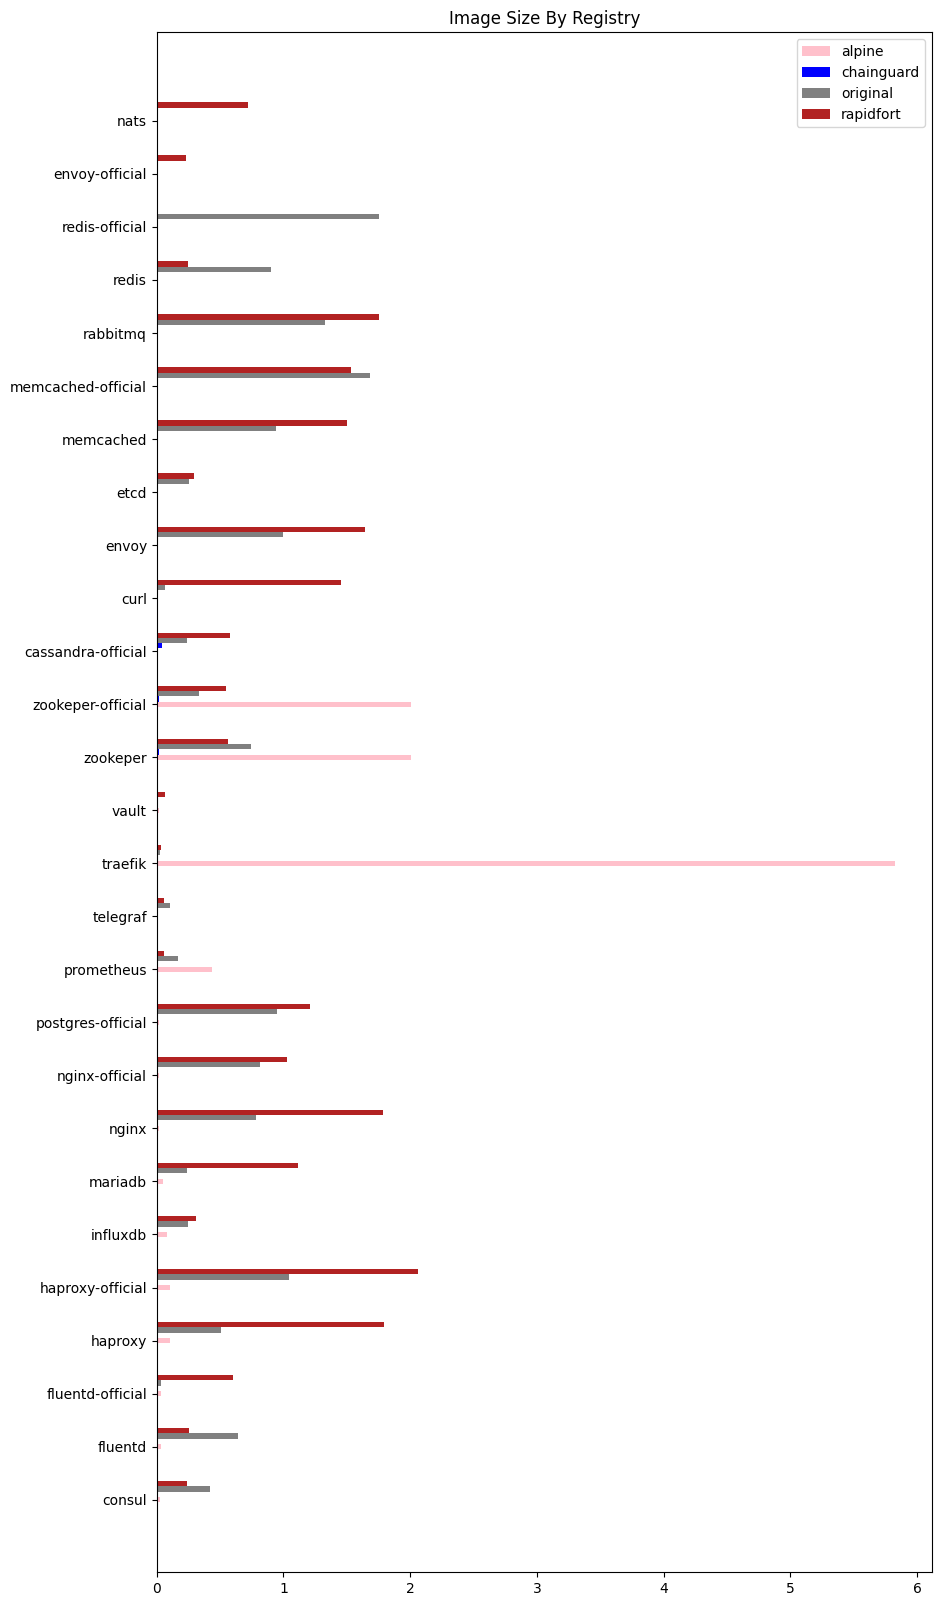

In [84]:
# Vulns per component by registry

plot_df(df, "vpc")